In [89]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.metrics import precision_score as ps

In [90]:
sp = yf.Ticker("^GSPC")
sp = sp.history(period="max")

<Axes: xlabel='Date'>

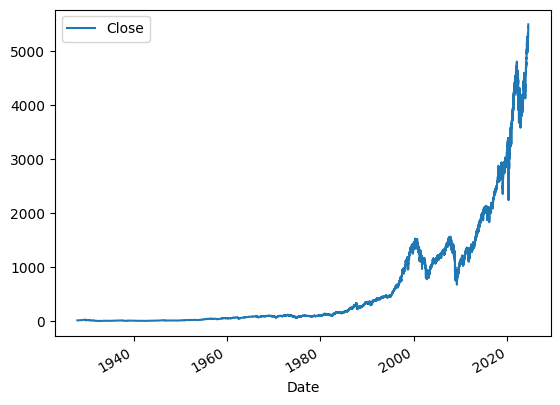

In [91]:
sp.plot.line(y="Close", use_index = True)

In [92]:
del sp["Dividends"]
del sp["Stock Splits"]

In [93]:
sp["Tomorrow"] = sp["Close"].shift(-1)
sp["Target"] = ((sp["Tomorrow"] > sp["Close"]).astype(int))
sp = sp.loc["1990-01-01":].copy()

In [94]:
def backtest(data, model, predictors, start=2500, step=250):
  all_predictions = []
  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)

  return pd.concat(all_predictions)

In [95]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []
for horizon in horizons:
  rolling_avg = sp.rolling(horizon).mean()
  ratio_col = f"Close_Ratio_{horizon}"
  sp[ratio_col] = sp["Close"] / rolling_avg["Close"]

  trend_col = f"Trend_{horizon}"
  sp[trend_col] = sp.shift(1).rolling(horizon).sum()["Target"]

  new_predictors += [ratio_col, trend_col]

In [96]:
model = rfc(n_estimators=200, min_samples_split = 50, random_state=1)

In [97]:
sp = sp.dropna()

In [98]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict_proba(test[predictors]) [:,1]
  preds[preds>=.60] = 1
  preds[preds < .60] = 0
  preds = pd.Series(preds, index=test.index, name = "Predictions")
  combined = pd.concat([test["Target"], preds], axis=1)
  return combined

In [99]:
predictions = backtest(sp, model, new_predictors)

In [100]:
predictions["Predictions"].value_counts()

Predictions
0.0    5017
1.0     163
Name: count, dtype: int64

In [101]:
ps(predictions["Target"], predictions["Predictions"])

0.5644171779141104

In [102]:
sp

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-10 00:00:00-04:00,5341.220215,5365.790039,5331.520020,5360.790039,3622280000,5375.319824,1,1.001289,1.0,1.003664,3.0,1.031883,33.0,1.132566,139.0,1.274758,530.0
2024-06-11 00:00:00-04:00,5353.000000,5375.950195,5327.250000,5375.319824,3568030000,5421.029785,1,1.001353,2.0,1.003229,3.0,1.033823,34.0,1.134670,139.0,1.277522,531.0
2024-06-12 00:00:00-04:00,5409.129883,5447.250000,5409.129883,5421.029785,3962840000,5433.740234,1,1.004234,2.0,1.009236,3.0,1.041707,34.0,1.143307,139.0,1.287680,531.0


In [103]:
predictions

,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,0.0
2003-11-18 00:00:00-05:00,1,0.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,1,0.0
...,...,...
2024-06-10 00:00:00-04:00,1,0.0
2024-06-11 00:00:00-04:00,1,0.0
2024-06-12 00:00:00-04:00,1,0.0
